In [1]:
# Ni Utils
from nilearn.datasets import fetch_spm_auditory
from nilearn.plotting import plot_anat, plot_img, plot_stat_map
from nilearn.image import concat_imgs, mean_img
from nilearn.glm.first_level import FirstLevelModel

# Plotting Utils
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt

# Table Utils
import pandas as pd

In [2]:
subject_data = fetch_spm_auditory()
print(*subject_data.func[:5], sep="\n")  # print paths of first 5 func images

/Users/andrewlizarraga/nilearn_data/spm_auditory/sub001/fM00223/fM00223_004.img
/Users/andrewlizarraga/nilearn_data/spm_auditory/sub001/fM00223/fM00223_005.img
/Users/andrewlizarraga/nilearn_data/spm_auditory/sub001/fM00223/fM00223_006.img
/Users/andrewlizarraga/nilearn_data/spm_auditory/sub001/fM00223/fM00223_007.img
/Users/andrewlizarraga/nilearn_data/spm_auditory/sub001/fM00223/fM00223_008.img


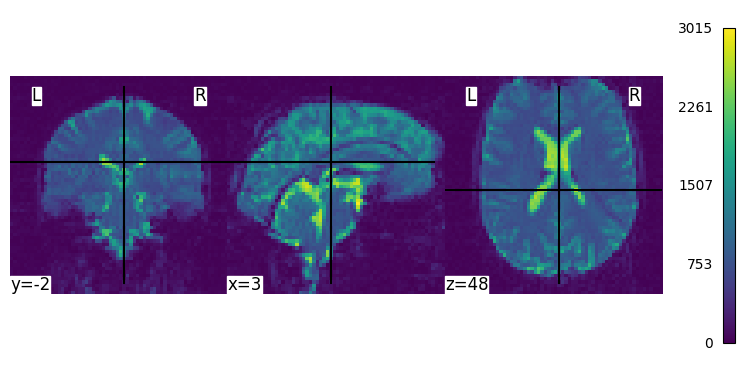

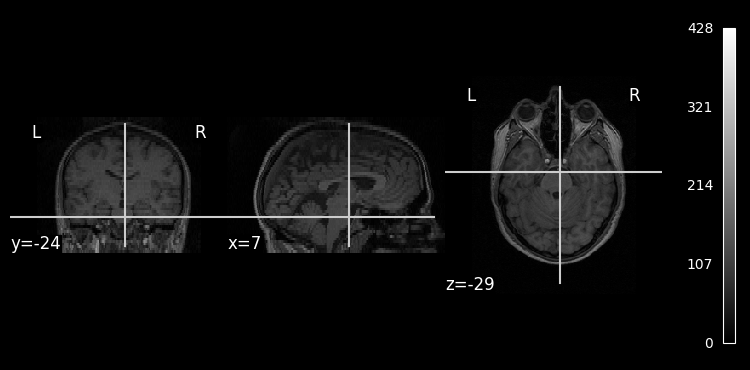

In [3]:
# Display the functional image
plot_img(subject_data.func[0], colorbar=True, cbar_tick_format="%i")
# Display the subject anatomy
plot_anat(subject_data.anat, colorbar=True, cbar_tick_format="%i")

In [4]:
# Concatenate all the 3D Echo Planar Images (EPI) into a single 4D image, then we average them 
# in order to create a background image that will be used to display the activations
fmri_img = concat_imgs(subject_data.func)
mean_img = mean_img(fmri_img)

In [5]:
# In fMRI, we typically have resting state and active state
# rest == scanning the subject while they are relaxed and not doing anything
# active state == we give the subject a task (for example look at an image, solve a puzzle, say something, ect)
events = pd.read_table(subject_data["events"])
events

,onset,duration,trial_type
0,0.0,42.0,rest
1,42.0,42.0,active
2,84.0,42.0,rest
3,126.0,42.0,active
4,168.0,42.0,rest
5,210.0,42.0,active
6,252.0,42.0,rest
7,294.0,42.0,active
8,336.0,42.0,rest
9,378.0,42.0,active


# Standard GLM Analysis in fMRI

The General Linear Model is the most common model used to fit fMRI data, 
where one linear model is fit to each voxel time course.

Nilearn provides a `FirstLevelModel` object, that will generate the design matrix
using the information from the `events` table

In [6]:
# The following is the standard design of fMRI analysis
# You do not need to know the details of the specifics of the parameters
fmri_glm = FirstLevelModel(
    t_r=7,                  # is the time of repetition of acquisitions
    noise_model="ar1",      # specifies the noise covariance model: lag-1 dependence
    standardize=False,      # we don't rescale the time series to mean 0, variance 1
    hrf_model="spm",        # we rely on the SPM (Statistical Parametric Mapping) model
    drift_model="cosine",   # we model the signal drifts as slow oscillating time functions
    high_pass=0.01,         # defines the cutoff frequency
)

In [7]:
# Run the GLM on the fMRI image
fmri_glm = fmri_glm.fit(fmri_img, events)

# Inspect the design matrix
# rows represent time, and columns are predictors
design_matrix = fmri_glm.design_matrices_[0]

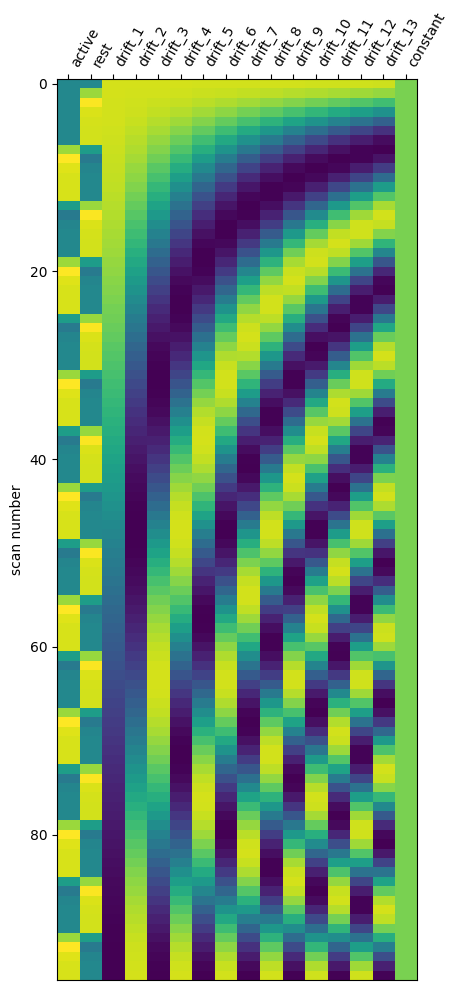

In [8]:
# Plot the design Matrix
plot_design_matrix(design_matrix)
plt.show()

In [9]:
design_matrix.iloc[[1,0]]

,active,rest,drift_1,drift_2,drift_3,drift_4,drift_5,drift_6,drift_7,drift_8,drift_9,drift_10,drift_11,drift_12,drift_13,constant
7.0,0.0,0.817784,0.144164,0.143643,0.142775,0.141564,0.140012,0.138122,0.135900,0.133351,0.130480,0.127294,0.123802,0.120012,0.115933,1.0
0.0,0.0,0.000000,0.144318,0.144260,0.144164,0.144029,0.143855,0.143643,0.143392,0.143103,0.142775,0.142410,0.142006,0.141564,0.141084,1.0
